In [1]:
import pandas as pd
import re
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    RobertaTokenizer, RobertaForSequenceClassification,
    BertModel,
    Trainer, TrainingArguments
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
import numpy as np


In [10]:
# ===== 数据加载与基础清洗 =====
df = pd.read_csv("labeled_news_comments.csv")
df['body'] = df['body'].astype(str).apply(lambda x: re.sub(r'http\S+|www.\S+', '', x))
df['body'] = df['body'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['body'], df['label'], test_size=0.2, stratify=df['label'], random_state=42
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [16]:
# ===== 通用 Dataset 类 =====
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        return item

# ===== 1. BERT 基础模型 =====
def run_bert():
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    train_enc = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
    val_enc = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128)
    train_dataset = TextDataset(train_enc, train_labels)
    val_dataset = TextDataset(val_enc, val_labels)

    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
    model.to(device)
    training_args = TrainingArguments(
        output_dir="./bert_results",
        eval_strategy="epoch",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=2,  # 测试用1轮，可改
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=10,
        save_strategy="no"
    )

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=1)
        precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
        acc = accuracy_score(labels, preds)
        return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )

    trainer.train()
    return trainer.evaluate()

# ===== 2. RoBERTa =====
def run_roberta():
    tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
    train_enc = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
    val_enc = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128)
    train_dataset = TextDataset(train_enc, train_labels)
    val_dataset = TextDataset(val_enc, val_labels)

    model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
    model.to(device)
    training_args = TrainingArguments(
        output_dir="./roberta_results",
        eval_strategy="epoch",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=2,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=10,
        save_strategy="no"
    )

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=1)
        precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
        acc = accuracy_score(labels, preds)
        return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )

    trainer.train()
    return trainer.evaluate()

# ===== 3. BERT + CNN =====
class BertCNNClassifier(nn.Module):
    def __init__(self, bert_model_name="bert-base-uncased", num_classes=2):
        super().__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.conv1 = nn.Conv1d(in_channels=768, out_channels=256, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs.last_hidden_state.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = self.pool(x).squeeze(2)
        logits = self.fc(x)
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
        return {"loss": loss, "logits": logits}

def run_bert_cnn():
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    train_enc = tokenizer(list(train_texts), truncation=True, padding=True, max_length=256)
    val_enc = tokenizer(list(val_texts), truncation=True, padding=True, max_length=256)
    train_dataset = TextDataset(train_enc, train_labels)
    val_dataset = TextDataset(val_enc, val_labels)

    model = BertCNNClassifier()
    model.to(device)
    training_args = TrainingArguments(
        output_dir="./bert_cnn_results",
        eval_strategy="epoch",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=2,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=10,
        save_strategy="no"
    )

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=1)
        precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
        acc = accuracy_score(labels, preds)
        return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )

    trainer.train()
    return trainer.evaluate()


In [12]:

# ===== 4. 依存句法 + SVM =====
def run_dep_svm():
    nlp = spacy.load("en_core_web_sm", disable=["ner"])

    def extract_dependency_features(text):
        doc = nlp(text)
        deps = [token.dep_ + "_" + token.head.text for token in doc]
        return " ".join(deps)

    train_dep = [extract_dependency_features(t) for t in train_texts]
    val_dep = [extract_dependency_features(t) for t in val_texts]

    vectorizer = TfidfVectorizer(max_features=5000)
    X_train = vectorizer.fit_transform(train_dep)
    X_val = vectorizer.transform(val_dep)

    clf = LinearSVC(class_weight='balanced')
    clf.fit(X_train, train_labels)

    preds = clf.predict(X_val)
    precision, recall, f1, _ = precision_recall_fscore_support(val_labels, preds, average='macro')
    acc = accuracy_score(val_labels, preds)
    return {"eval_accuracy": acc, "eval_precision": precision, "eval_recall": recall, "eval_f1": f1}

In [6]:
# ===== 主程序 =====
results = {}

In [17]:
results["BERT"] = run_bert()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
D:\Tang Heqiang\Documents\Assignment\PythonProject\.venv\Lib\site-packages\torch\nn\modules\module.py:1784: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.209100,0.222017,0.905386,0.832500,0.865858,0.847592
2,0.101600,0.295083,0.919484,0.877696,0.838839,0.856411


D:\Tang Heqiang\Documents\Assignment\PythonProject\.venv\Lib\site-packages\torch\nn\modules\module.py:1784: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
D:\Tang Heqiang\Documents\Assignment\PythonProject\.venv\Lib\site-packages\torch\nn\modules\module.py:1784: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [18]:
results["RoBERTa"] = run_roberta()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
D:\Tang Heqiang\Documents\Assignment\PythonProject\.venv\Lib\site-packages\torch\nn\modules\module.py:1784: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.310200,0.269795,0.897100,0.828801,0.816647,0.822509
2,0.189700,0.241639,0.913404,0.865491,0.829702,0.845956


D:\Tang Heqiang\Documents\Assignment\PythonProject\.venv\Lib\site-packages\torch\nn\modules\module.py:1784: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
D:\Tang Heqiang\Documents\Assignment\PythonProject\.venv\Lib\site-packages\torch\nn\modules\module.py:1784: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [19]:
results["BERT+CNN"] = run_bert_cnn()

D:\Tang Heqiang\Documents\Assignment\PythonProject\.venv\Lib\site-packages\torch\nn\modules\module.py:1784: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.236000,0.234293,0.899439,0.821398,0.868819,0.841751
2,0.083500,0.291987,0.918916,0.875379,0.839723,0.855977


D:\Tang Heqiang\Documents\Assignment\PythonProject\.venv\Lib\site-packages\torch\nn\modules\module.py:1784: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
D:\Tang Heqiang\Documents\Assignment\PythonProject\.venv\Lib\site-packages\torch\nn\modules\module.py:1784: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [7]:
results["Dep+SVM"] = run_dep_svm()

In [20]:
df_results = pd.DataFrame(results).T
print("\n模型性能对比：")
print(df_results)


模型性能对比：
          eval_accuracy  eval_precision  eval_recall   eval_f1  eval_loss  \
Dep+SVM        0.731792        0.649582     0.730680  0.656052        NaN   
BERT           0.919484        0.877696     0.838839  0.856411   0.295083   
RoBERTa        0.913404        0.865491     0.829702  0.845956   0.241639   
BERT+CNN       0.918916        0.875379     0.839723  0.855977   0.291987   

          eval_runtime  eval_samples_per_second  eval_steps_per_second  epoch  
Dep+SVM            NaN                      NaN                    NaN    NaN  
BERT          118.1117                  253.421                 15.841    2.0  
RoBERTa       113.2905                  264.206                 16.515    2.0  
BERT+CNN      256.1849                  116.837                  7.303    2.0  


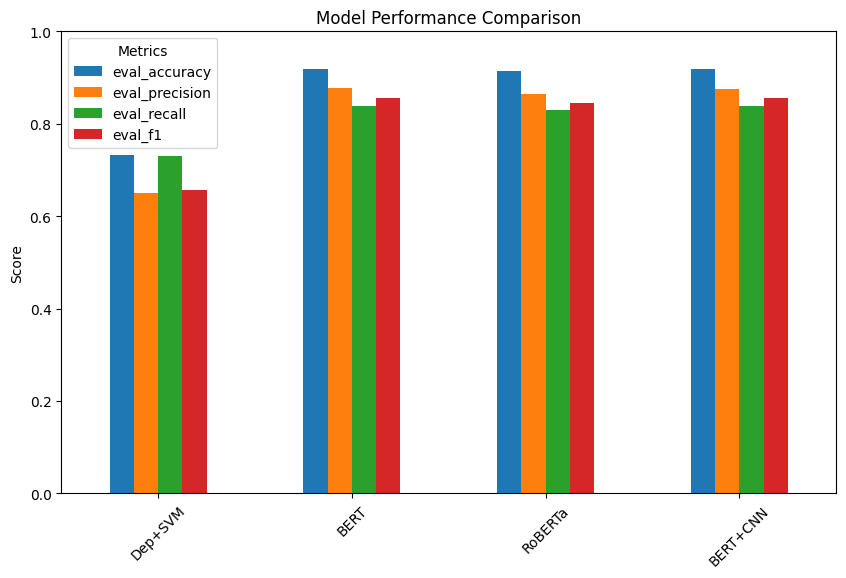

In [21]:
import matplotlib.pyplot as plt

# 只取核心指标
metrics = ["eval_accuracy", "eval_precision", "eval_recall", "eval_f1"]
df_plot = df_results[metrics]

df_plot.plot(kind="bar", figsize=(10, 6))
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(title="Metrics")
plt.show()


In [22]:
plt.savefig("compare.png")

<Figure size 640x480 with 0 Axes>

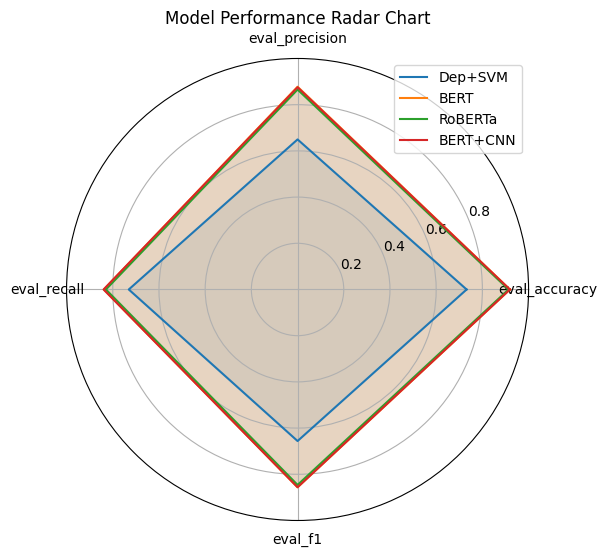

<Figure size 640x480 with 0 Axes>

In [23]:
import numpy as np

metrics = ["eval_accuracy", "eval_precision", "eval_recall", "eval_f1"]
labels = df_results.index.tolist()

angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for model in labels:
    values = df_results.loc[model, metrics].tolist()
    values += values[:1]
    ax.plot(angles, values, label=model)
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
ax.set_yticks([0.2, 0.4, 0.6, 0.8])
ax.set_ylim(0, 1)
plt.title("Model Performance Radar Chart")
plt.legend()
plt.show()
plt.savefig("Radar_Chart.png")

C:\Users\Tang Heqiang\AppData\Local\Temp\ipykernel_31528\1930590277.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(df_results["eval_runtime"][i]+2, df_results["eval_f1"][i], model)


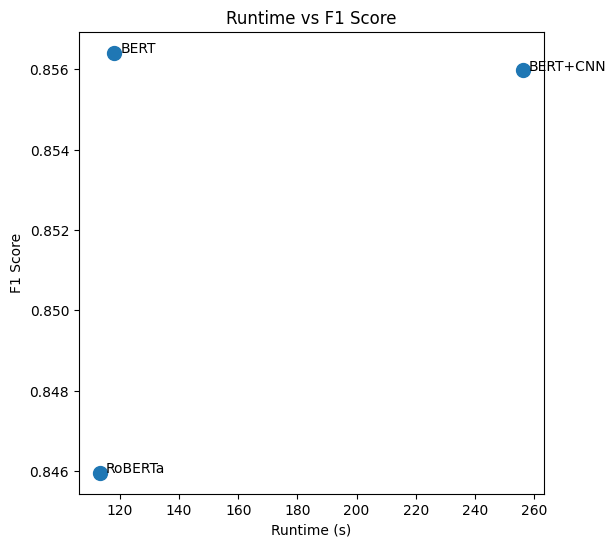

In [24]:
plt.figure(figsize=(6, 6))
plt.scatter(df_results["eval_runtime"], df_results["eval_f1"], s=100)

for i, model in enumerate(df_results.index):
    plt.text(df_results["eval_runtime"][i]+2, df_results["eval_f1"][i], model)

plt.xlabel("Runtime (s)")
plt.ylabel("F1 Score")
plt.title("Runtime vs F1 Score")
plt.show()


In [25]:
import json

df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'model'}, inplace=True)

data_js = "var modelResults = " + json.dumps(df_results.to_dict(orient="records"), ensure_ascii=False) + ";"

with open("model_results.js", "w", encoding="utf-8") as f:
    f.write(data_js)

print("✅ 已保存为 model_results.js")


✅ 已保存为 model_results.js


In [26]:
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'model'}, inplace=True)
df_results.to_csv("model_results.csv", index=False)
